## Parcel routing

In [1]:
from matplotlib import pyplot as plt
import networkx as nx
import scipy.stats as stats
import numpy as np
import random

In [73]:
#For each node, the number of packages appearing per day would be hovering around 
#a certain point. Consider the number of packages is sampled from a normal distribution, 
#we need to create a mean and sd of that node.

def node_parameter (network_size, lower, upper):
    Node_parameter = []
    random.seed(1)
    for i in range (network_size): 
        mean = random.randint (lower, upper)
        sd = int (mean/5)
        Node_parameter.append([mean,sd])
    return Node_parameter

Node_parameter = node_parameter (20,10,40)

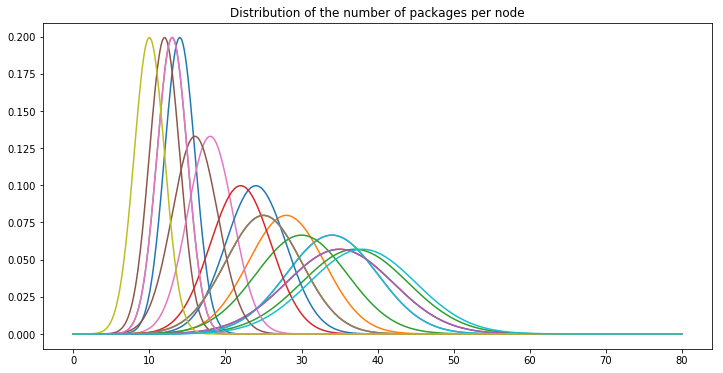

In [172]:
#Draw 20 normal distributions of all the nodes
import scipy.stats as sts
plt.figure (figsize = (12,6))
plot_x = np.linspace (0, 80, 500)
for i in Node_parameter:
    plot_y = sts.norm.pdf(plot_x, loc = i[0], scale = i[1])
    plt.plot (plot_x,plot_y,label='norm pdf')
plt.title('Distribution of the number of packages per node')
plt.show()

In [134]:
class Parcel_routing:
    #Intitate the 
    def __init__ (self, network_size = 20, watts_strogatz = 1, degree = 3, random_seed = 1):
        self.network_size = network_size
        self.degree = degree
        self.watts_strogatz = watts_strogatz
        random.seed(random_seed)
        
        #Do you want Watts_Strogatz or Barbarasi_Albert model?
        if self.watts_strogatz == 1: 
            self.graph = nx.watts_strogatz_graph(self.network_size, self.degree, 0.5)
            while nx.is_connected(self.graph) is False:
                self.graph = nx.watts_strogatz_graph(self.network_size, self.degree, 0.5)
        else:
            self.graph = nx.barabasi_albert_graph(self.network_size, self.degree)
    
    def initialization (self, capacity = 400):
        #For each edge, create a capacity for the line
        for edge in self.graph.edges:
            self.graph.edges[edge]['capacity'] = capacity
        
        #Let's define the parameter for each node. A node also store all the packages
        for node in self.graph.nodes:
            self.graph.nodes[node]['package'] = []
            self.graph.nodes[node]['param'] = Node_parameter[node]
        
        self.layout = nx.spring_layout(self.graph)
        
        self.package_history = [] #Storing the performance of the simulation
        self.step = 0 #Starting at 0 time step
                   
    def create_package (self):
        #Let's create the number of packages that equals to the amount that we have agreed, shall we?
        for node in self.graph.nodes:
            package_number = int(np.random.normal (self.graph.nodes[node]['param'][0], self.graph.nodes[node]['param'][1]))
            i = 0
            while i < package_number:
                to_city = np.random.randint (self.network_size)
                if to_city is not node:
                    self.graph.nodes[node]['package'].append(to_city)
                    i+=1
    
    '''
    
    For the transportation function:
    
    . For each node in the graph => create a list of neighbors, capacity of transportation line to corresponding
    neighbors, the list of the current packages, a list of edge that is at the full capacity 
    . For each package in the node, check if there is a path from the current node to the final destination. If yes, 
    find the next hub and reduce the capacity by 1. 
    . If the transportation line is at its full capacity, remove the line so that a package will have a to find another
    shortest path. When removing an edge, append the neighbor city that has the line removed. We will retrieve all removed 
    lines after finishing the transportation of all packages.
    
    '''
    
    def transportation (self):
        #For each node in the graph
        for node in self.graph.nodes:
            #Available neighbors of the current node
            neighbors = [n for n in self.graph.neighbors(node)] 
            
            #Capacity of the transportation lines to corresponding neighbors
            capacity = [self.graph.edges[(node,i)]['capacity'] for i in neighbors] 
            orginal_capacity = capacity.copy()
            
            #Package list
            package_list = self.graph.nodes[node]['package'] 
            package_list_2 = package_list.copy()
            
            remove_edge = [] #When the capacity is reached, I will copy that neighbor to the removed node. 
                                #I will revive all the removed nodes at the end of the function
            
            #For each package in the node
            for i in package_list_2: 
                #Hurray, the node has arrived at the final destination
                if i == node: 
                    package_list.remove(i)
                
                else: 
                    if nx.has_path(self.graph,node,i) == True: #If there is a path from one node to another 
                        next_city = nx.shortest_path (self.graph, node, i)[1] #Find the next destination for the packages
                        package_list.remove(i) #Remove package from the package list
                        self.graph.nodes[next_city]['package'].append (i) #Next city receives packages
                        capacity[neighbors.index(next_city)] -= 1 #Reduce the capacity 
                        if capacity[neighbors.index (next_city)] == 0: #If no more capacity, then remove the edge
                            remove_edge.append(next_city)
                            self.graph.remove_edge(node, next_city)
            
            #Let's retrieve all the removed edges
            for removed_node in remove_edge:
                self.graph.add_edge(node, removed_node)
                self.graph.edges[(node,removed_node)]['capacity'] = orginal_capacity[neighbors.index(removed_node)]
            
            #End of the transportation, updating the current package    
            self.graph.nodes[node]['package'] = package_list 
        
        #How many packages per node ath the moment
        self.package_history.append(np.sum([len(sim.graph.nodes[node]['package']) 
                                            for node in sim.graph.nodes])/self.network_size)   
        
        self.step +=1

    def observe(self, para_details = False):
        '''
        Draw the state of the network.
        '''
        plt.figure(figsize=(10,5))
        plt.subplot(1, 2, 1)
        plt.plot(self.package_history)
        plt.xlabel('step')
        plt.ylabel('average package remaining')
        plt.xlim(0, 200)
        plt.ylim(0, np.max(self.package_history) * 1.05)
        plt.title('Step: ' + str(self.step))
        plt.show()
        
        plt.subplot(1, 2, 2)
        self.layout = nx.spring_layout(self.graph, pos = self.layout)
        plt.clf()
        color_map = []
        for node in self.graph.nodes:
            if len (self.graph.nodes[node]['package']) < self.graph.nodes[node]['param'][0]:
                color_map.append('blue')
            if len (self.graph.nodes[node]['package']) < self.graph.nodes[node]['param'][0]*5:
                color_map.append('orange')
            else:
                color_map.append('red')
        nx.draw(
            self.graph, pos=self.layout, with_labels=True,
            node_color=color_map,
            edge_color=[self.graph.edges[i, j]['capacity'] for i, j in self.graph.edges],
            alpha=0.5, vmin=0, vmax=1)
        plt.title('Step: ' + str(self.step))
        print ('')

## Testing the code for one-time implementation

<Figure size 432x288 with 0 Axes>

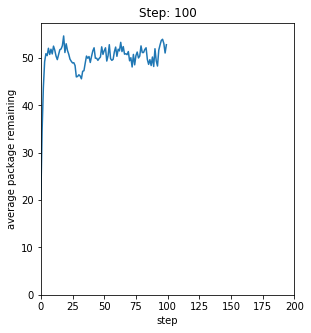


Maximum number of remaining packages 55
Average number of packages throughout the system is 49.97


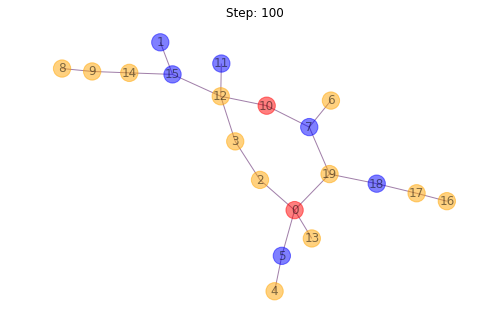

In [146]:
sim = Parcel_routing(network_size = 20, watts_strogatz = 1, degree = 3)
sim.initialization(capacity = 110)
for i in range (20):
    for i in range (5):
        sim.create_package()
        sim.transportation()
plt.figure()
sim.observe()

print('Maximum number of remaining packages {:.0f}'.format (np.max(sim.package_history)))
print('Average number of packages throughout the system is {:.2f}'.format (np.mean (sim.package_history)))

# current_package = [len(sim.graph.nodes[node]['package']) for node in sim.graph.nodes]
# plt.figure()
# plt.hist(current_package)
# plt.title('Package histogram')

## The working of the logistic system with Watts_Strogatz model

In [202]:
seed = []
max_pack = []
avg_pack = []

for i in range (15): 
    sim = Parcel_routing(network_size = 20, watts_strogatz = 1, degree = 3, random_seed = i)
    sim.initialization(capacity = 100)
    for n in range (100):
        sim.create_package()
        sim.transportation()
    max_pack.append(np.max(sim.package_history))
    avg_pack.append(np.mean(sim.package_history))

### Finding the best Watts_Strogatz graph construction

<Figure size 432x288 with 0 Axes>

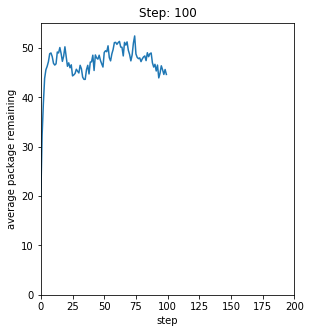

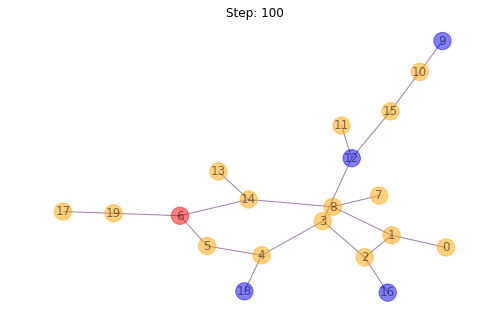

Maximum number of remaining packages 52
Average number of packages throughout the system is 47.11


In [203]:
best_seed = max_pack.index(np.min(max_pack))
sim = Parcel_routing(network_size = 20, watts_strogatz = 1, degree = 3, random_seed = best_seed)
sim.initialization(capacity = 100)
for n in range (100):
    sim.create_package()
    sim.transportation()

plt.figure()
sim.observe()
plt.show()

print('Maximum number of remaining packages {:.0f}'.format (np.max(sim.package_history)))
print('Average number of packages throughout the system is {:.2f}'.format (np.mean (sim.package_history)))

In [204]:
#Average shortest path
print(nx.average_shortest_path_length(sim.graph))

3.8789473684210525


## Testing the working of the logistic system with Barbarasi_Albert model

In [191]:
seed = []
max_pack = []
avg_pack = []

for i in range (10): 
    sim = Parcel_routing(network_size = 20, watts_strogatz = 0, degree = 3, random_seed = i)
    sim.initialization(capacity = 100)
    for n in range (100):
        sim.create_package()
        sim.transportation()
    max_pack.append(np.max(sim.package_history))
    avg_pack.append(np.mean(sim.package_history))

### Finding the best Barbarasi_Albert graph construction

<Figure size 432x288 with 0 Axes>

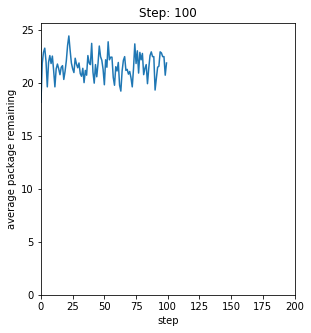

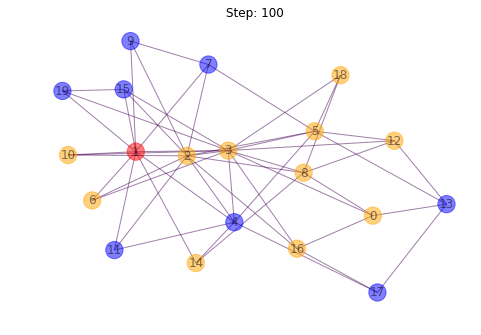

Maximum number of remaining packages 24
Average number of packages throughout the system is 21.57


In [192]:
best_seed = max_pack.index(np.min(max_pack))
sim = Parcel_routing(network_size = 20, watts_strogatz = 0, degree = 3, random_seed = best_seed)
sim.initialization(capacity = 100)
for n in range (100):
    sim.create_package()
    sim.transportation()

plt.figure()
sim.observe()
plt.show()

print('Maximum number of remaining packages {:.0f}'.format (np.max(sim.package_history)))
print('Average number of packages throughout the system is {:.2f}'.format (np.mean (sim.package_history)))

### Finding the lowest capacity for the given the Barbarasi_Albert model

In [193]:
seed = []
max_pack = []
avg_pack = []

accepted_capacity = []
for a in np.linspace (50,10,5):
    for i in range (100): 
        sim = Parcel_routing(network_size = 20, watts_strogatz = 0, degree = 3, random_seed = best_seed)
        sim.initialization(capacity = a)
        for n in range (100):
            sim.create_package()
            sim.transportation()
        max_pack.append(np.max(sim.package_history))
        avg_pack.append(np.mean(sim.package_history))
    if np.max(max_pack) > 50:
        break
    else: 
        accepted_capacity.append(a)

In [194]:
accepted_capacity

[50.0, 40.0, 30.0, 20.0]

In [198]:
import time 
start = time.time ()
best_seed = max_pack.index(np.min(max_pack))
package_history = []
for i in range (50):
    sim = Parcel_routing(network_size = 20, watts_strogatz = 0, degree = 3, random_seed = best_seed)
    sim.initialization(capacity = 30) #Well, I tried capacity = 20 but it did not converge
    for n in range (200):
        sim.create_package()
        sim.transportation()
    package_history.append (sim.package_history)
end = time.time()
print ('Running time is {:.2f}'.format (end - start))

Running time is 138.26


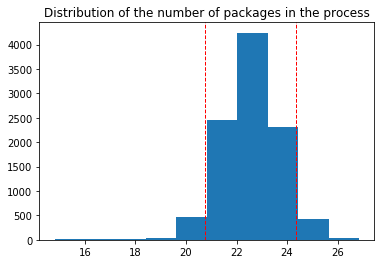

Average number of packages per node is 22.57
Upper bound of the number of packages per node is 24.4
Lower bound of the number of packages per node is 20.8


In [199]:
flatten = (np.array(package_history)).flatten()
upper = np.percentile (flatten, 95)
lower = np.percentile (flatten, 5)
plt.hist (flatten)
plt.axvline (upper, linestyle='dashed', color = 'red', linewidth=1)
plt.axvline (lower, linestyle='dashed', color = 'red', linewidth=1)
plt.title ('Distribution of the number of packages in the process')
plt.show()

print('Average number of packages per node is {:.2f}'.format (np.mean (flatten)))
print('Upper bound of the number of packages per node is {:.1f}'.format (upper))
print('Lower bound of the number of packages per node is {:.1f}'.format (lower))

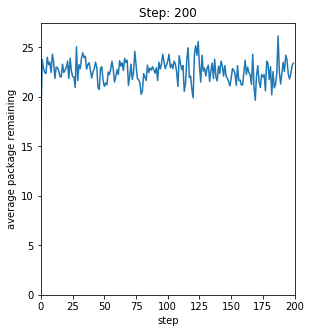

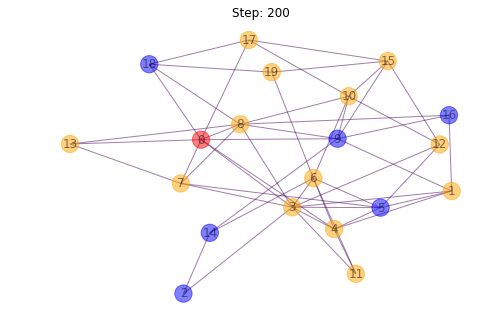

In [200]:
#See the average number of packages converge and the construction of the model
sim.observe()

In [201]:
#Average shortest path length
print(nx.average_shortest_path_length(sim.graph))

1.9210526315789473
